In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
from scipy.signal import butter, filtfilt, freqz
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

# Load Data

In [5]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo'], verbose=False)
dt = get_sample_interval(f, units='s')
lfp = f['lfp']

# Fit VAR Model

In [6]:
dt = 0.001 # s
window = 5 # s
window = int(window/dt) # ms


residuals = {}
sigma_us = {}

# for area in session_info['areas']:
for area in ['vlPFC']:
    electrode_inds = np.where(electrode_info['area'] == area)[0]
    num_win = int(np.ceil(lfp.shape[1]/window))
    sigma_us[area] = np.zeros((num_win, len(electrode_inds), len(electrode_inds)))
    
    residuals[area] = np.zeros((len(electrode_inds), lfp.shape[1] - 1))
    
    for i, t in enumerate(tqdm(np.arange(0,lfp.shape[1],window))):         

        lfp_chunk = lfp[electrode_inds, max(0,t-1):t+window].T
        model = VAR(lfp_chunk)
        results = model.fit(1)
        
        sigma_us[area][i] = results.sigma_u
        
        resid = results.resid
        window_start = ((window - 1)*(i != 0) + window*max(0, i-1))
        residuals[area][:, window_start:window_start+resid.shape[0]] = resid.T

In [10]:
ones = np.ones((2, 10))

In [15]:
ones.sum(axis=0)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [16]:
ones

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## Pick Signal

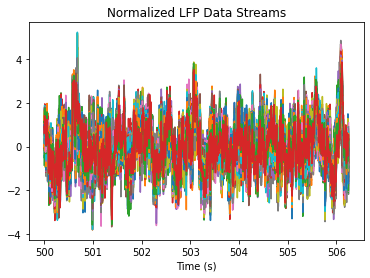

In [7]:
# ======================
# SIGNAL PARAMETERS
# ======================

area = 'vlPFC'
# unit_indices = [0, 10, 20]
unit_indices = np.where(electrode_info['area'] == area)[0]
# trajectory_start_times = np.arange(0, 7001, 500) # s
start_time = 500 # s
duration = 6.25 # s
percent_training_data = 0.8


# ------------------
# get signal
# ------------------
start_step = int(start_time/dt)
length = int(duration/dt)
lfp_pts = lfp[unit_indices, start_step:start_step + length].T
# normalize (gaussian normalization)
for i in range(lfp_pts.shape[1]):
    lfp_pts[:, i] = (lfp_pts[:, i] - np.mean(lfp_pts[:, i]))/np.std(lfp_pts[:, i])
var_names = [f"unit_{unit_num} {electrode_info['area'][unit_num]}" for unit_num in unit_indices]
time_vals = np.arange(start_time, start_time+duration, dt)

for i in range(lfp_pts.shape[1]):
    plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
plt.xlabel('Time (s)')
plt.title("Normalized LFP Data Streams")
# plt.legend()

plt.show()

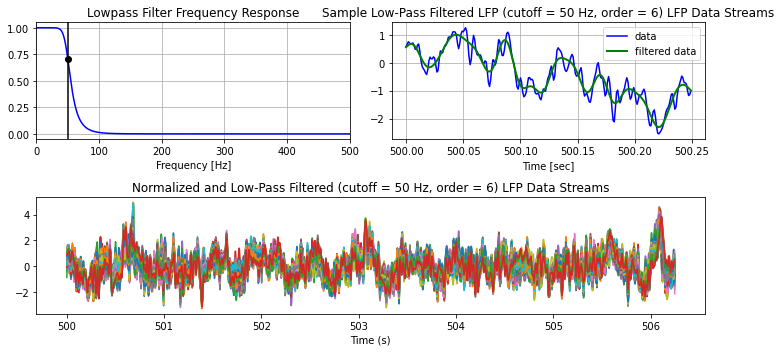

In [8]:
# FILTERING

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 1/dt      # sample rate, Hz
cutoff = 50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

plt.figure(figsize=(10, 5))

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 2, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Demonstrate the use of the filter.
length = 250
data = lfp_pts[:length, 1]

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 2, 2)
plt.plot(time_vals[:length], data, 'b-', label='data')
plt.plot(time_vals[:length], y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.title(f"Sample Low-Pass Filtered LFP (cutoff = {cutoff} Hz, order = {order}) LFP Data Streams")

plt.subplot(2, 1, 2)
for i in range(lfp_pts.shape[1]):
    lfp_pts[:, i] = butter_lowpass_filter(lfp_pts[:, i], cutoff, fs, order)
for i in range(lfp_pts.shape[1]):
    plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
plt.xlabel('Time (s)')
plt.title(f"Normalized and Low-Pass Filtered (cutoff = {cutoff} Hz, order = {order}) LFP Data Streams")

# plt.subplots_adjust(hspace=0.35)
plt.tight_layout()
plt.show()

## Residuals From Relevant Section

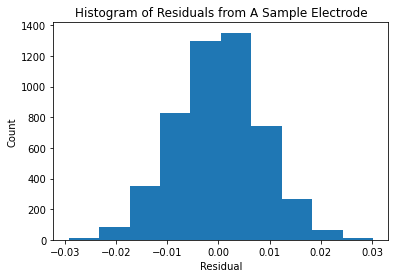

In [9]:
start_step = int(start_time/dt)
num_train_steps = int(duration*percent_training_data/dt)
residuals_train = residuals[area][:,start_step:start_step + num_train_steps]

plt.figure()
plt.title("Histogram of Residuals from A Sample Electrode")
plt.hist(residuals_train[0])
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

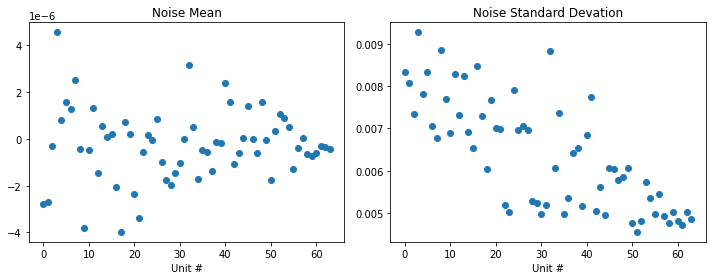

In [10]:
noise_mean = np.mean(residuals_train, 1)
noise_std = np.std(residuals_train, 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(lfp_pts.shape[1]), noise_mean)
plt.xlabel("Unit #")
plt.title("Noise Mean")
plt.subplot(1, 2, 2)
plt.scatter(np.arange(lfp_pts.shape[1]), noise_std)
plt.xlabel("Unit #")
plt.title("Noise Standard Devation")

plt.tight_layout()
plt.show()

# Run Network

In [14]:
noise_mean = np.zeros(lfp_pts.shape[1])
noise_cov = sigma_us[area][int(start_step/window)]
train_noise = np.random.multivariate_normal(noise_mean, noise_cov, size=(num_train_steps,))

In [15]:
# ======================
# RESERVOIR PARAMETERS
# ======================

D_r = 800 # number of reservoir nodes
d = int((6/299)*(D_r-1)) # average degree of Erdos-Renyi network
p = None # probability of an edge in the Erdos-Renyi network - if not None, overrides d
rho = 1.2 # spectral radius of the adjacency matrix

# beta = 0
beta = 1e-5 # regularization parameter
# sigma = 0.1 # maximum value of the input weights
sigma = 1/np.sqrt(300)

squared_inds = None

In [16]:
reservoir = ReservoirDS(lfp_pts, dt=dt, D_r=D_r, d=d, p=p, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)
reservoir.train_and_test(percent_training_data, train_noise=None)

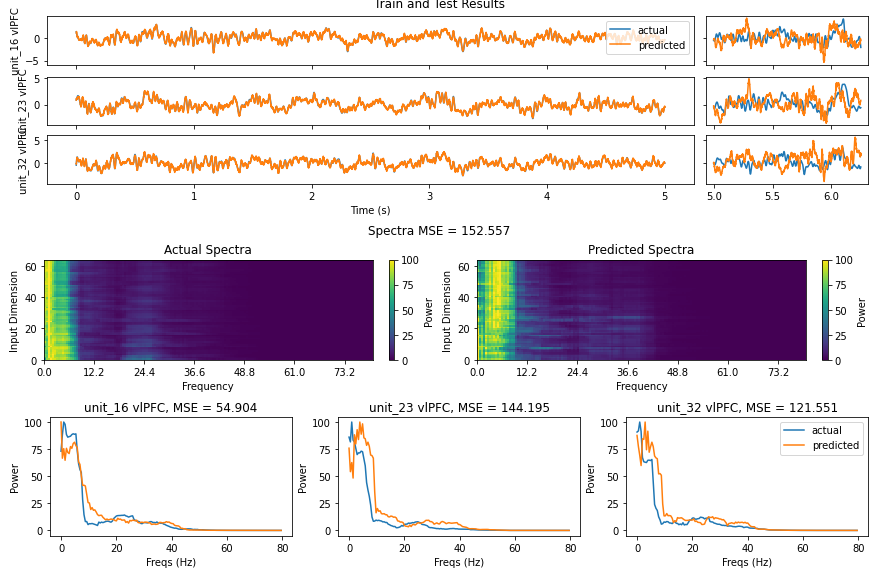

In [17]:
reservoir.plot_all()

In [32]:
reservoir.compute_lyap_spectrum_QR(debug=True)

Computing Jacobians



Computing Lyapunov spectrum


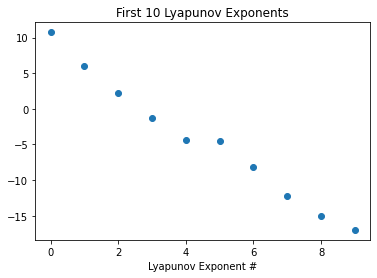

In [33]:
num = 10
plt.scatter(np.arange(num), reservoir.lyaps[:num])
plt.xlabel('Lyapunov Exponent #')
plt.title(f"First {num} Lyapunov Exponents")
plt.show()